## Installing the required libraries

In [4]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#import all of the required libraries and classes right here


import pandas as pd
import re
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.simplefilter('ignore')

## Data Ingestion

In [5]:
df=pd.read_excel('Coffee_shop_data.xlsx')
population=pd.read_csv('population.csv',skiprows=[0])

In [6]:
population.head()

,Geography,Label for GEO_ID,Race/Ethnic Group,Population Groups,Total,Errata of Total,Total!!1-person household,Total!!2-person household,Total!!3-person household,Total!!4-person household,Total!!5-person household,Total!!6-person household,Total!!7-or-more-person household
0,8600000US89010,ZCTA5 89010,1,Total population,172,NaN,51,69,19,12,12,4,5
1,8600000US89019,ZCTA5 89019,1,Total population,1164,NaN,412,421,134,83,57,32,25
2,8600000US89060,ZCTA5 89060,1,Total population,4144,NaN,1106,1714,550,361,222,95,96
3,8600000US89061,ZCTA5 89061,1,Total population,2109,NaN,469,936,283,206,112,62,41
4,8600000US89439,ZCTA5 89439,1,Total population,671,NaN,193,314,88,55,17,2,2


In [7]:
df.head()#checking first five rows

,ID no.,Business Name,Street address,City,State,Zip Code,Phone,Rating,Gender majority,Median Salary,Latte Price
0,1,Brew Haven,8 Old Shore Place,Oakland,California,94616,415-810-4769,4.5,Male,72463,3.31000
1,2,Bean Bliss,6650 Clarendon Crossing,Stockton,California,95210,209-701-1665,5.0,Female,87117,5.35000
2,3,Caffeine Cove,7281 Buell Road,Fresno,California,93773,559-137-3554,4.7,Male,86394,4.15000
3,4,Mug Magic,670 Jackson Avenue,Torrance,California,90510,818-789-5573,4.3,Male,88343,5.34000
4,5,Daily Grind,37 Ludington Terrace,San Diego,California,92196,619-354-2389,1.6,Male,77795,4.51175


In [8]:
# check for data info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID no.           1000 non-null   int64  
 1   Business Name    1000 non-null   object 
 2   Street address   1000 non-null   object 
 3   City             1000 non-null   object 
 4   State            1000 non-null   object 
 5   Zip Code         1000 non-null   int64  
 6   Phone            1000 non-null   object 
 7   Rating           1000 non-null   float64
 8   Gender majority  1000 non-null   object 
 9   Median Salary    1000 non-null   int64  
 10  Latte Price      1000 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 86.1+ KB


In [9]:
#check the number of records and features
df.shape

(1000, 11)

In [10]:
population.shape

(1705, 13)

In [11]:
# get basic stats about the data
df.describe()

,ID no.,Zip Code,Rating,Median Salary,Latte Price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,92976.163000,3.784600,81182.842000,5.061491
std,288.819436,1706.943177,1.150717,5142.670356,0.352002
min,1.000000,90005.000000,1.000000,72001.000000,3.090000
25%,250.750000,91751.750000,3.200000,76776.000000,4.830175
50%,500.500000,92883.000000,4.240000,81113.000000,5.062450
75%,750.250000,94257.000000,4.580000,85684.000000,5.310025
max,1000.000000,96154.000000,5.000000,89978.000000,6.480000


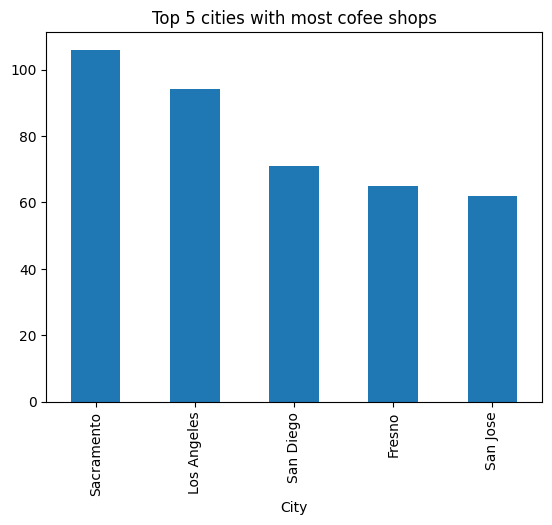

In [12]:
ax=df['City'].value_counts().head(5).plot(kind='bar')
ax.set_title('Top 5 cities with most cofee shops')
plt.show()

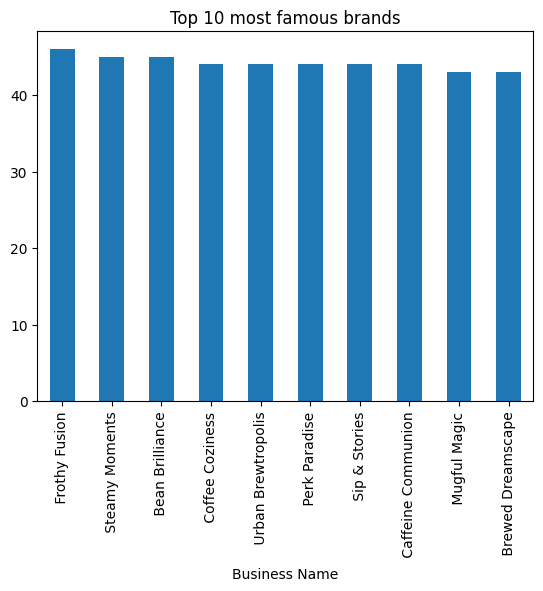

In [13]:
ax=df['Business Name'].value_counts().head(10).plot(kind='bar')
ax.set_title('Top 10 most famous brands')
plt.show()

## Data Preprocessing

In [14]:
df.isna().sum()
# no null values
# if we have null values we would impute it. If we have numberical replace mean. Missing values - replace it with the mode (most occuring values)

ID no.             0
Business Name      0
Street address     0
City               0
State              0
Zip Code           0
Phone              0
Rating             0
Gender majority    0
Median Salary      0
Latte Price        0
dtype: int64

In [16]:
#converting zipcode to object data (str) - We need to join the zip code with the population data. Converting the coffee shop data. In order to store it into alphanumerical value, it should be string.
df['Zip Code']=df['Zip Code'].astype(str)

In [17]:
#extract zip code from population
# Find all of the zipcode that has a 5 digit pattern. Getting the last 5 digits from the population zip code. Creating a new column called zip code

def find_zip_code(geocode):
    pattern = r'\d{5}$'

    match = re.search(pattern, geocode)

    if match:
        zip_code = match.group(0)
    return zip_code


In [18]:
# The actual coversion is below. The above is the function

population['Zip Code']=population['Geography'].apply(find_zip_code)

In [19]:
cafe_data=df.copy()
# merging the population via zip code as population is an important feature to determing the price / locations
df=pd.merge(cafe_data,population)
#notice that the data size is reduced afer a join

In [20]:
#keeping only Total from population. In the pop dataset, keeping total population column and other columns.
columns=cafe_data.columns.values.tolist()+['Total']
df=df[columns]
#rename Total to Population
df=df.rename(columns={"Total":"Population"})

In [21]:
df

,ID no.,Business Name,Street address,City,State,Zip Code,Phone,Rating,Gender majority,Median Salary,Latte Price,Population
0,2,Bean Bliss,6650 Clarendon Crossing,Stockton,California,95210,209-701-1665,5.00,Female,87117,5.35000,11180
1,6,Espresso Elegance,8427 Atwood Road,Visalia,California,93291,559-929-4731,1.20,Female,78753,5.31765,15310
2,10,Perk Palace,7 David Junction,Fresno,California,93726,559-323-2365,4.20,Female,80973,5.30665,13942
3,11,The Coffee Cartel,6018 Rockefeller Center,Orange,California,92867,714-292-8390,1.90,Male,74340,4.43900,13284
4,14,Grindhouse Cafe,7846 Cherokee Junction,Visalia,California,93291,559-253-9426,4.50,Male,78753,5.27165,15310
...,...,...,...,...,...,...,...,...,...,...,...,...
407,982,Perk Paradise,4 Park Meadow Crossing,Van Nuys,California,91411,818-584-8823,4.00,Female,76034,4.99170,9177
408,983,Urban Brewtropolis,2459 Golden Leaf Place,Santa Monica,California,90405,818-215-2671,4.82,Female,86920,4.98200,14376
409,985,Caffeine Communion,40 Sommers Parkway,San Jose,California,95133,408-304-3646,4.04,Female,78176,4.64680,7365
410,998,Urban Brewtropolis,141 Burrows Place,Los Angeles,California,90035,323-785-4094,3.00,Male,87604,4.64000,12814


In [22]:
#keeping only relevant features
df= df[['Zip Code','Rating','Median Salary','Latte Price','Population']]
#df.shape


In [23]:
df.columns    

Index(['Zip Code', 'Rating', 'Median Salary', 'Latte Price', 'Population'], dtype='object')

In [24]:
# Calculate the total number of coffee shops for each zip code
coffee_shop_counts = df['Zip Code'].value_counts().reset_index()
coffee_shop_counts.columns = ['Zip Code', 'CoffeeShopCount']

# Ensure 'Zip Code' is of type string in both DataFrames
df['Zip Code'] = df['Zip Code'].astype(str)
coffee_shop_counts['Zip Code'] = coffee_shop_counts['Zip Code'].astype(str)

# Merge the counts back into the original DataFrame
df = df.merge(coffee_shop_counts, on='Zip Code', how='left')

# Print the updated DataFrame
print(df)

# Criteria:
# a. High population
# b. Low total number of coffee shops
# c. Low ratings
# d. High median salary

# Sorting the DataFrame based on the criteria
sorted_df = df.sort_values(by=['Population', 'CoffeeShopCount', 'Rating', 'Median Salary'],
                           ascending=[False, True, True, False]).reset_index(drop=True)


    Zip Code  Rating  Median Salary  Latte Price  Population  CoffeeShopCount
0      95210    5.00          87117      5.35000       11180                4
1      93291    1.20          78753      5.31765       15310                7
2      93726    4.20          80973      5.30665       13942                5
3      92867    1.90          74340      4.43900       13284                9
4      93291    4.50          78753      5.27165       15310                7
..       ...     ...            ...          ...         ...              ...
407    91411    4.00          76034      4.99170        9177                8
408    90405    4.82          86920      4.98200       14376                3
409    95133    4.04          78176      4.64680        7365                6
410    90035    3.00          87604      4.64000       12814                5
411    92867    4.50          74340      3.82000       13284                9

[412 rows x 6 columns]


In [25]:
# Created a list - if length of list 5, if the zip code is already present, it will not add that into the list. 
# Deduping zip code column and displaying all of the records for the top 5.
lst=[]
for i in range(len(sorted_df)):
    if len(lst)!=5:
        if (sorted_df['Zip Code'][i]) not in lst:
            lst.append(sorted_df['Zip Code'][i])
            
# Filter 'sorted_df' to include only rows where 'Zip Code' is in 'lst'
top_5_zip_codes_df = sorted_df[sorted_df['Zip Code'].isin(lst)]

top_5_zip_codes_df

,Zip Code,Rating,Median Salary,Latte Price,Population,CoffeeShopCount
0,94110,2.22,74020,5.04500,27128,5
1,94110,3.50,74020,5.04700,27128,5
2,94110,4.40,74020,5.05900,27128,5
3,94110,4.50,74020,4.77900,27128,5
4,94110,4.70,74020,4.58100,27128,5
5,90805,3.00,88140,5.47900,26056,4
6,90805,3.89,88140,5.31900,26056,4
7,90805,4.31,88140,5.02100,26056,4
8,90805,4.37,88140,5.20700,26056,4
9,95823,4.30,73165,4.96825,22470,3


In [26]:
X = df.drop(['Latte Price', 'Zip Code'], axis=1)  # Features excluding 'Latte Price' and 'Zip Code'
y = df['Latte Price']  # Target variable


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
#scaling
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

Model Selection

In [31]:
#Model Selection
models = {
    'Linear Regresion': LinearRegression(),
    'Randon Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}


In [32]:
#Hyperparameter Tuning
param_grid = {
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]},
}


In [33]:
for model_name, model in models.items():
    if model_name in param_grid:
        # Perform hyperparameter tuning using GridSearchCV
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X, y)

        # Set the best hyperparameters to the model
        models[model_name] = grid_search.best_estimator_


Model Trainin and Evaluation

In [34]:
#Model Training
for model_name, model in models.items():
    model.fit(X_train, y_train)

In [36]:
# Model Evaluation
for model_name, model in models.items():
    # Evaluate the model on the testing set
    y_pred = model.predict(X_test)
    print(f"{model_name} Metrics:")
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print("R-squared:", r2_score(y_test, y_pred))
    print()



Linear Regresion Metrics:
Mean Absolute Error: 0.21737899529390034
Mean Squared Error: 0.06581667796516916
R-squared: 0.44342320694160287

Randon Forest Metrics:
Mean Absolute Error: 0.2413519480780261
Mean Squared Error: 0.08141530380965285
R-squared: 0.31151388825439896

Gradient Boosting Metrics:
Mean Absolute Error: 0.21849548692918733
Mean Squared Error: 0.06693132091089583
R-squared: 0.43399726179642195



In [ ]:
#We want this dataframe to be same as the training data so that model can predict the value
zip_codes_df= top_5_zip_codes_df.drop(['Zip Code', 'Latte Price'], axis=1)
zip_codes_df= sc.transform(zip_codes_df)

In [ ]:
for model_name, model in models.items():
    # Predict the prices for lattes in the top 5 zip codes
    predicted_prices = model.predict(zip_codes_df)
    print(f"{model_name} Predicted Prices for Top 5 Zip Codes:")
    print(predicted_prices)
    print()

In [ ]:
predictions = {}

for model_name, model in models.items():
    # Predict the prices for lattes in the top 5 zip codes
    predicted_prices = model.predict(zip_codes_df)
    predictions[model_name] = predicted_prices

# Convert the predictions dictionary to a DataFrame
predictions_df = pd.DataFrame(predictions)
# Add the zip codes to the predictions DataFrame
predictions_df['Zip Code'] = top_5_zip_codes_df['Zip Code'].values

# Rearrange the columns to have 'Zip Code' as the first column
cols = ['Zip Code'] + [col for col in predictions_df.columns if col != 'Zip Code']
predictions_df = predictions_df[cols]

predictions_df

In [ ]:
agg_df = predictions_df.groupby('Zip Code')['Gradient Boosting'].agg([("Highest", "max"), ("Lowest", "min")]).reset_index()
agg_df.columns = ['Zip Code', 'Highest', 'Lowest']
print(agg_df)